# Celltype classification using zero-shot learning


One known downstream application of RNA foundation models is cell-type classification. However, it is not always easy to know which foundation model will perform best and working with different bio foundation models is time consuming. With the Helical package, we have streamlined this task and made foundation models interchangaeble.

In the example notebook, we levarge Helical for using Geneformer model for classifying cell types and evaluate them on a labelled data set.
It also serves a template on to use those models in a standardised way in your own applications.

### Zero-shot learning
The technique where a model learns to recognize and categorize objects or concepts without being explicitly trained on examples of those categories

# **AI_hackathon25 instructions**
Modify the code as following:  
1- subset the single cell data to 200 cells.  
2- Split the cells into 180 cells for training, and 20 cells for testing  
3- use geneformer model of 6 layers and 4096 genes   
4- define the batch size by 20 cells  


## 1) Imports 
Let's start by importing all the packages used in this notebook

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd
import numpy as np
import logging
import torch
from helical.utils import get_anndata_from_hf_dataset
from datasets import load_dataset

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

# Import Geneformer & UCE from the Helical package
from helical.models.geneformer import Geneformer,GeneformerConfig



INFO:datasets:PyTorch version 2.6.0 available.


## 2) Dataset loading and Splitting

We first load the human fetal yolk sac scRNA-seq data from the Helical Hugging Face datasets.

The yolk sac (YS) generates the first blood and immune cells and provides nutritional and metabolic support to the developing embryo.

There are three granularity levels of cell annotation you can access in the data.

For example purposes we use the least granular LVL1 cell annotation.

Let's start by running the command below to download the data set automatically (this could take a few seconds):

In [2]:
import anndata as ad

ann_data = ad.read_h5ad("../yolksac_human.h5ad")

We split the data in a train and test sets

In [3]:
import anndata as ad
from sklearn.model_selection import train_test_split


# Shuffle the AnnData object by its observations (cells)
ann_data = ann_data[ann_data.obs.sample(frac=1, random_state=42).index]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test = train_test_split(ann_data[:100], test_size=0.2, random_state=42)

# Now you have train_adata and test_adata while keeping the AnnData structure intact
print(X_train)
print(X_test)

View of AnnData object with n_obs × n_vars = 80 × 37318
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3', 'LVL3_for_embryo_study'
    var: 'n_cells'
    obsm: 'X_umap'
View of AnnData object with n_obs × n_vars = 20 × 37318
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3', 'LVL3_for_embryo_study'
    var: 'n_cells'
    obsm: 'X_umap'


## 3) Zero Shot prediction with Geneformer

### 3.1) Model training and inference

The first time you execute the cell below, the model weights will be downloaded automatically, this could take a few seconds:

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_config = GeneformerConfig(batch_size=10,device=device)   
geneformer = Geneformer(configurer=model_config)

In [5]:
# The "process_data"-function from the Helical package pre-processes the data. 
# It takes AnnData as an input. 
# More information in our documentation
train_dataset = geneformer.process_data(X_train)
test_dataset = geneformer.process_data(X_test)




Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [6]:
ref_embeddings = geneformer.get_embeddings(train_dataset)
test_embeddings = geneformer.get_embeddings(test_dataset)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# **AI Hackathon25 instructions**  
How many rows are generated in your training set embeddings?    
How many genes in the training set embeddings?  
How many embeddings (numbers, d_model) per gene?  

In [7]:
print(f"Number of embeddings: {len(embeddings)}")
print(f"Genes per embedding: {len(embeddings[0])}")
print(f"Values per gene embedding: {len(embeddings[0].iloc[0])}")

NameError: name 'embeddings' is not defined

### 3.2) Visualization with UMAP
Let's visualize the embeddings leveraging UMAP. The idea is simple: can we identify clusters of cells that the models considers as being similar enough to put them close in space ? If this hypothesis happens to be true, the models can be used to infer cell types based on a few hand-labelled cells!

In the cell below, we plot our outputs once without labels and onc with the labels from our dataset (which in a real-world setup would of course not be available).

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

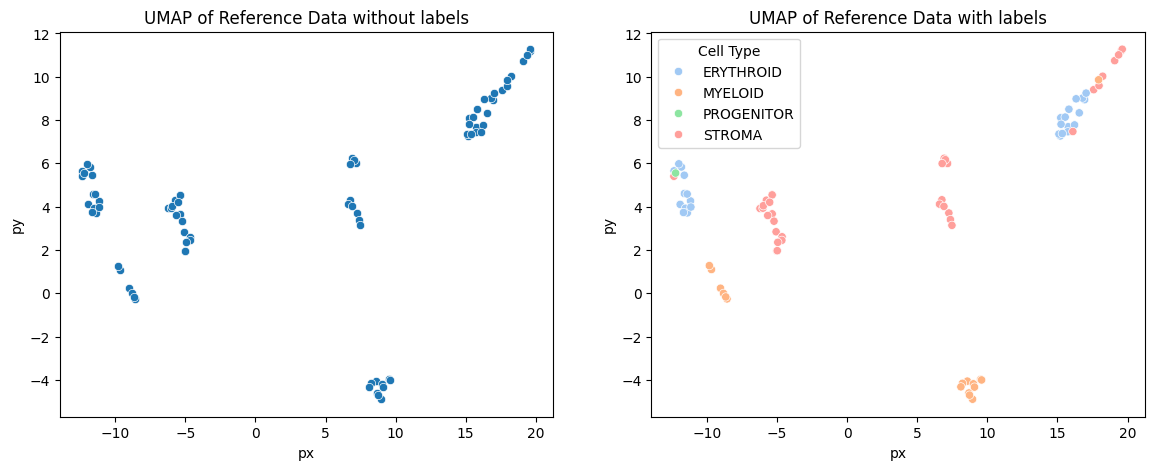

In [8]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(ref_embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = X_train.obs['LVL1']
plot_df['Cell Type'] = labels.values


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

This looks great! Geneformer seems to be capable to cluster cells according to their cell type. Let's explore how we can leverage this capability to infer cell types on an unlabelled data set.

## 4) Prediction: Leverage your hand-labelled cells to predict label of other cells

We can use a K-Neirhbours classifier(k-nearest neighbors)to predict cell types on an unlabelled data set. We have separated our data set into a train and test set. Let's use the train set to train a classifier and predict labels on the "unseen" test set. We can then use the labels in this test set to evaluate how accurate our prediction was.

In [9]:
labels = X_train.obs['LVL1']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

KNeighborsClassifier(metric='cosine')

In [10]:
pred_labels = neigh.predict(test_embeddings)

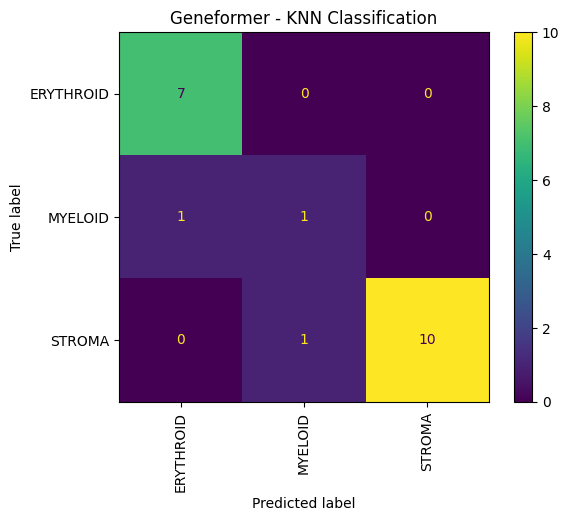

In [11]:
cm_geneformer = confusion_matrix(X_test.obs['LVL1'],pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_geneformer, display_labels=np.unique(np.concatenate((X_test.obs['LVL1'], pred_labels))))
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()

In [12]:
print(classification_report(X_test.obs['LVL1'],pred_labels))

              precision    recall  f1-score   support

   ERYTHROID       0.88      1.00      0.93         7
     MYELOID       0.50      0.50      0.50         2
      STROMA       1.00      0.91      0.95        11

    accuracy                           0.90        20
   macro avg       0.79      0.80      0.80        20
weighted avg       0.91      0.90      0.90        20

